## import & utils


In [1]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from tqdm.auto import trange
import jraph
import numpy as np

pl.style.use("dark_background")


def np2pil(a):
    a = np.asarray(a)
    if a.dtype.kind == "f":
        a = np.uint8(a.clip(0, 1) * 255)
    return PIL.Image.fromarray(a)


def imshow(a):
    display(np2pil(a))


def zoom(a, k=2):
    return np.repeat(np.repeat(a, k, 1), k, 0)


def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]
    pad = (w - len(a)) % w
    a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), "constant")
    h = len(a) // w
    a = a.reshape([h, w] + list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w] + list(a.shape[4:]))
    return a

In [2]:
import jax
import jax.numpy as jp
import optax
from flax import nnx

In [3]:
%load_ext autoreload
%autoreload 2

## Params

In [4]:
from boolean_nca_cc import generate_layer_sizes

In [5]:
input_n, output_n = 8, 8
arity = 4
layer_sizes = generate_layer_sizes(input_n, output_n, arity, layer_n=4)
loss_type = "l4"

In [6]:
layer_sizes

[(8, 1), (64, 4), (64, 4), (64, 4), (32, 2), (8, 1)]

## Training


### BackProp

In [7]:
from boolean_nca_cc.circuits.model import gen_circuit
from boolean_nca_cc.circuits.train import TrainState, train_step
from boolean_nca_cc.circuits.viz import evaluate_and_visualize
from boolean_nca_cc.circuits.tasks import get_task_data

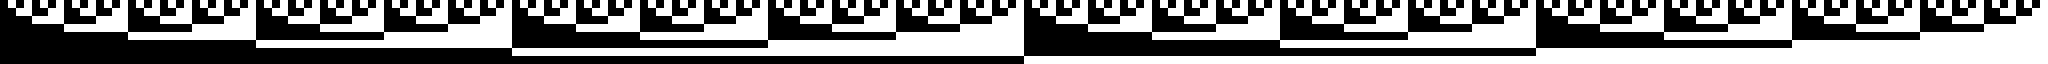

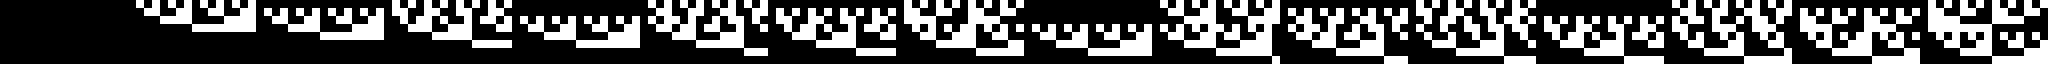

In [8]:
key = jax.random.PRNGKey(42)
wires, logitsbp = gen_circuit(key, layer_sizes, arity=arity)

opt = optax.adamw(1, 0.8, 0.8, weight_decay=1e-1)
state = TrainState(params=logitsbp, opt_state=opt.init(logitsbp))


case_n = 1 << input_n
x = jp.arange(case_n)
x, y0 = get_task_data(
    "binary_multiply", case_n, input_bits=input_n, output_bits=output_n
)

zoom_factor = 8
imshow(zoom(x.T, zoom_factor))
imshow(zoom(y0.T, zoom_factor))

In [9]:
loss_log_bp = []
aux_log_bp = []

In [10]:
pbar = trange(100)
for i in pbar:
    loss, aux, state = train_step(state, opt, wires, x, y0, loss_type, do_train=True)
    loss_log_bp.append(loss)
    aux_log_bp.append(aux)
    pbar.set_postfix_str(
        f"loss: {loss.item():.3E}, accuracy: {aux['accuracy'].item():.2%}"
        + (
            f" | hard_loss: {aux['hard_loss'].item():.3E}, hard_accuracy: {aux['hard_accuracy'].item():.2%}"
            if "hard_loss" in aux
            else ""
        )
    )

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
%timeit train_step(state, opt, wires, x, y0, loss_type, do_train=True)

5.22 ms ± 93.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


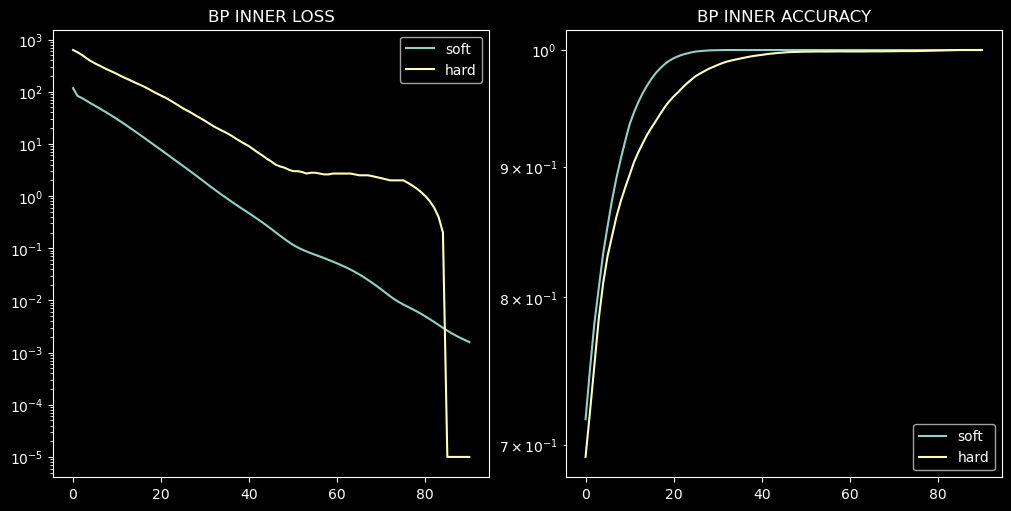

In [12]:
def plot_losses(
    loss_log, aux_log, figax=None, title=None, plot_accuracy=False, plot_hard=True
):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    v = len(loss_log) // 10

    if not plot_accuracy:
        smooth_losses = np.convolve(loss_log, np.ones(v) / v, mode="valid")
        hard_losses = [aux["hard_loss"] for aux in aux_log]
        smooth_hard_losses = np.convolve(hard_losses, np.ones(v) / v, mode="valid")
        ax.plot(smooth_losses, label="soft")
        if plot_hard:
            ax.plot(jp.maximum(smooth_hard_losses, 1e-5), label="hard")
    else:
        accs = [aux["accuracy"] for aux in aux_log]
        smooth_accs = np.convolve(accs, np.ones(v) / v, mode="valid")
        ax.plot(smooth_accs, label="soft")
        hard_accs = [aux["hard_accuracy"] for aux in aux_log]
        smooth_hard_accs = np.convolve(hard_accs, np.ones(v) / v, mode="valid")
        if plot_hard:
            ax.plot(smooth_hard_accs, label="hard")

    ax.legend()
    ax.set_yscale("log")

    if title is not None:
        ax.set_title(title)


fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True
)
plot_losses(loss_log_bp, aux_log_bp, (fig, axs[0]), title="BP INNER LOSS")
plot_losses(
    loss_log_bp,
    aux_log_bp,
    (fig, axs[1]),
    plot_accuracy=True,
    title="BP INNER ACCURACY",
)

In [13]:
bp_results = {
    "losses": loss_log_bp,
    "aux_log": aux_log_bp,
}

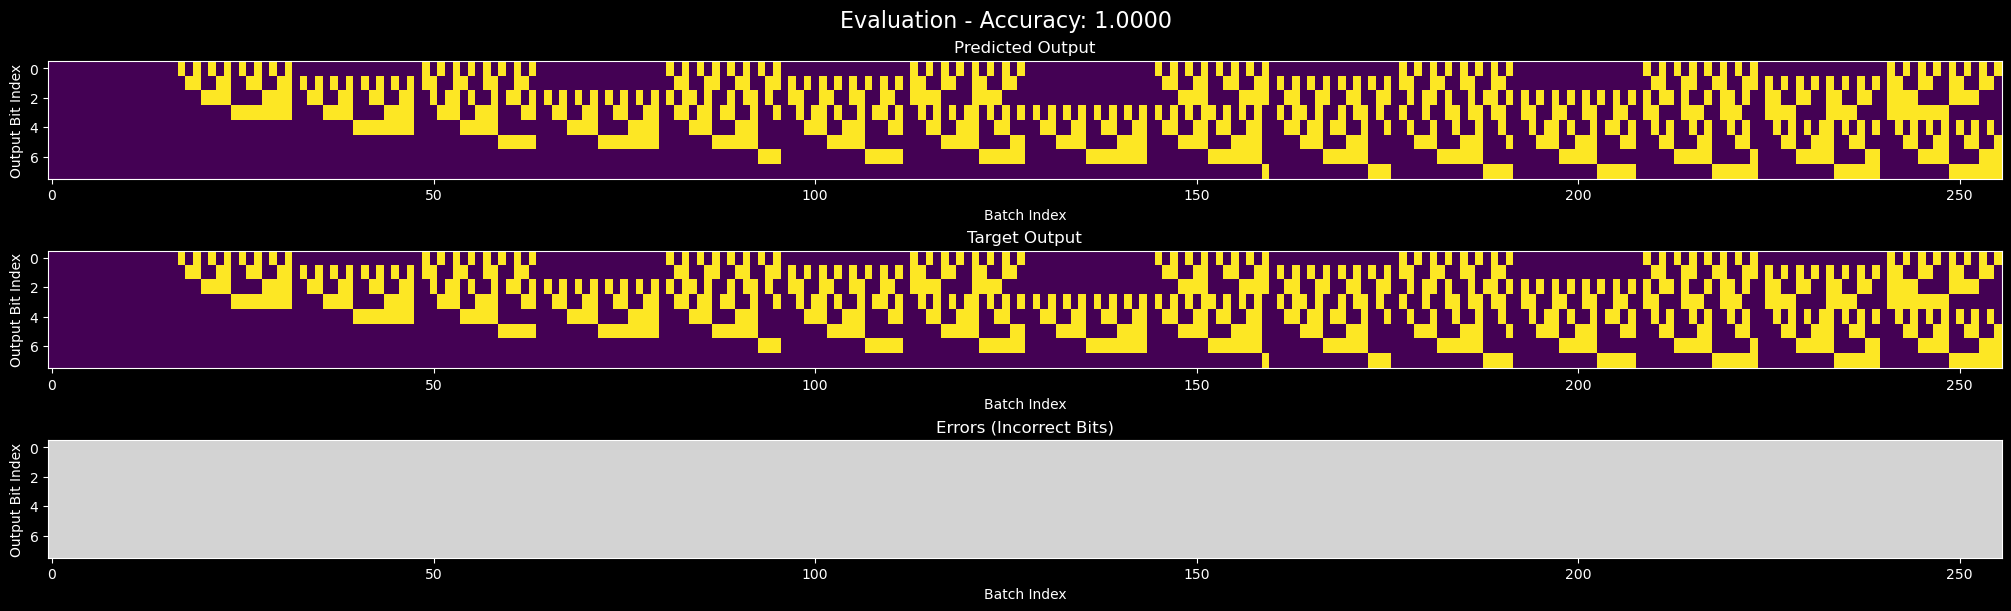

In [14]:
metrics = evaluate_and_visualize(state.params, wires, x, y0, hard=True)

In [15]:
raise KeyboardInterrupt()

KeyboardInterrupt: 

In [16]:
from boolean_nca_cc.utils import build_graph, extract_logits_from_graph
from boolean_nca_cc.circuits.train import loss_f_l4

### GNN

In [112]:
from boolean_nca_cc.models import CircuitGNN, run_gnn_scan
from boolean_nca_cc.training import train_model

In [90]:
hidden_dim = 64
hidden_features = 64
n_message_steps = 5
loss, aux = loss_f_l4(logitsbp, wires, x, y0)
graph = build_graph(
    logitsbp, wires, input_n, arity, hidden_dim=hidden_dim, loss_value=loss
)

gnn = CircuitGNN(
    hidden_dim=hidden_dim,
    message_passing=True,
    node_mlp_features=[hidden_features, hidden_features],
    edge_mlp_features=[hidden_features, hidden_features],
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    use_attention=False,
    arity=arity,
)

opt_fn = optax.adamw(1e-4, weight_decay=1e-5)
opt = nnx.Optimizer(gnn, opt_fn)

In [91]:
def loss_fn(gnn: CircuitGNN, graph: jraph.GraphsTuple, wires: jax.Array = wires):
    updated_graph = run_gnn_scan(gnn, graph, n_message_steps)
    updated_logits = extract_logits_from_graph(
        updated_graph, [l.shape for l in logitsbp]
    )
    loss, aux = loss_f_l4(updated_logits, wires, x, y0)
    return loss, updated_graph

In [92]:
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(gnn, graph)
opt.update(grads)
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(gnn, graph)
assert any(jax.tree.leaves(jax.tree.map(lambda x: x.any(), grads))), "No grads"

### Training

In [ ]:
gnn_results = train_model(
    key=0,
    # CIRCUIT PARAMS
    layer_sizes=layer_sizes,
    x_data=x,
    y_data=y0,
    arity=arity,
    # TRAINING PARAMS
    epochs=2**15,
    n_message_steps=1,
    meta_batch_size=256,
    # WIRING MODE PARAMS
    wiring_mode="fixed",
    wiring_fixed_key=jax.random.PRNGKey(42),
    # LOSS PARAMS
    loss_type="l4",
    # OPTIMIZER PARAMS
    learning_rate=1e-3,
    weight_decay=1e-5,
    # LEARNING RATE SCHEDULER
    lr_scheduler="linear_warmup",
    # INITIAL GNN AND OPTIMIZER
    hidden_dim=hidden_dim,
    init_gnn=gnn,
    # POOL PARAMS : current mean avg of 100 steps before reset
    use_pool=True,
    pool_size=1024,
    reset_pool_fraction=0.075,
    reset_pool_interval=2**5,
    reset_strategy="combined",
)

Training GNN:   0%|          | 0/32768 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [64]:
try:
    gnn_results["gnn"] = nnx.state(gnn_results["gnn"])
    gnn_results["optimizer"] = nnx.state(gnn_results["optimizer"])
except ValueError:
    print("already converted")
    pass

In [65]:
# save gnn_results
import pickle

with open("gnn_results.pkl", "wb") as f:
    pickle.dump(gnn_results, f)

In [66]:
# recreate aux in old format
aux_log = [
    {
        "accuracy": accuracies,
        "hard_accuracy": hard_acc,
        "hard_loss": hard_loss,
    }
    for accuracies, hard_acc, hard_loss in zip(
        gnn_results["accuracies"],
        gnn_results["hard_accuracies"],
        gnn_results["hard_losses"],
    )
]

In [67]:
gnn_save = CircuitGNN(
    hidden_dim=hidden_dim,
    message_passing=True,
    node_mlp_features=[hidden_features, hidden_features],
    edge_mlp_features=[hidden_features, hidden_features],
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    use_attention=False,
    arity=arity,
)

In [68]:
nnx.update(gnn_save, gnn_results["gnn"])

ValueError: Trying to update a non-Variable attribute 'aggregate_fn' with a Variable: State({
  'key_proj': {
    'bias': {
      'value': Array([ 5.42042835e-05,  5.68136820e-05, -4.49119652e-05, -5.13368241e-06,
             -1.12814589e-04,  1.34680374e-06, -2.34330437e-05, -5.22482878e-05,
             -4.81146672e-05,  1.57218037e-05, -4.76083769e-05,  7.05140556e-05,
              2.90258940e-05,  2.65164490e-05,  1.00154139e-04, -1.84809411e-04,
             -1.63040841e-05, -4.31391709e-05, -2.97201277e-05,  4.27917439e-05,
              7.80978080e-05,  5.65565460e-05,  2.26295044e-04, -2.37999830e-05,
              5.47787204e-05,  2.44467101e-05, -3.64357184e-05,  4.39558971e-05,
              1.12471906e-04,  3.09304196e-05,  1.72962573e-05, -6.28383568e-05,
              1.62077868e-05,  1.39732569e-04, -1.60672862e-05,  1.69253435e-05,
              9.21822430e-05,  8.74684338e-06,  5.23665085e-06, -1.45867270e-05,
              6.65305342e-05,  8.06888638e-05,  5.50581990e-06, -6.70754889e-05,
             -5.86546121e-05,  3.97699077e-05,  1.18914053e-04, -3.15626494e-05,
             -1.11842201e-04,  2.35998286e-05, -1.80446950e-05, -8.12500584e-05,
              4.40789772e-05, -1.70505853e-04,  6.35330143e-05, -2.65944163e-05,
             -7.34614696e-06, -3.30198236e-05,  9.58929468e-06,  6.27099462e-06,
             -2.33089704e-05, -3.06547663e-05, -1.02830809e-05,  4.76838286e-05,
             -5.91322132e-05,  3.41763189e-05, -3.19555620e-05, -5.43749302e-05,
              1.51735934e-04,  1.59982392e-05,  5.42084454e-05,  1.56962033e-05,
             -6.51821174e-05,  3.18556631e-05, -1.19194701e-05, -4.04544626e-05,
             -1.34438415e-05,  6.09839299e-05, -1.67485327e-04,  3.30090261e-05],      dtype=float32)
    },
    'kernel': {
      'value': Array([[-0.0344981 ,  0.20350723, -0.23092353, ...,  0.01887623,
              -0.26504758,  0.260144  ],
             [-0.03542649,  0.14157829,  0.21886106, ..., -0.10882957,
              -0.1448692 , -0.02231687],
             [-0.1846846 , -0.05533317, -0.01314437, ...,  0.04607437,
               0.1228806 , -0.02225229],
             ...,
             [-0.05294736, -0.0848569 , -0.08726558, ...,  0.12523092,
               0.07402105, -0.09077006],
             [-0.12197088, -0.06800427, -0.00962962, ...,  0.19119751,
               0.10872677,  0.03548558],
             [ 0.12556246, -0.11507021, -0.10413525, ..., -0.00072982,
               0.07662877,  0.11608708]], dtype=float32)
    }
  },
  'output_proj': {
    'bias': {
      'value': Array([ 0.03189076, -0.02755656, -0.02137397, -0.0108447 ,  0.01558236,
              0.00619591,  0.03058574,  0.00476464, -0.03711682,  0.00367537,
              0.0168059 ,  0.01769993,  0.0131904 , -0.01256783, -0.01331393,
             -0.00480626,  0.00074147,  0.02465481,  0.0053741 , -0.02645278,
             -0.00115803, -0.03508778, -0.02283592,  0.02309223,  0.00125586,
             -0.01812884,  0.00377591,  0.01667972,  0.01351495,  0.00701474,
             -0.03646347, -0.02071044, -0.00144535, -0.00214985,  0.05432328,
              0.02745412,  0.01616547,  0.00460437,  0.05927935, -0.02039117,
              0.03821767, -0.02217646, -0.03764983, -0.00478434, -0.02072413,
             -0.00037228,  0.00150815, -0.02952857,  0.00601214, -0.0097268 ,
              0.01323528,  0.00196591,  0.00577714, -0.00780732, -0.03105785,
             -0.03727906,  0.01236728, -0.02734672, -0.00019331, -0.03344504,
              0.0348719 ,  0.01302687,  0.01075343,  0.01749492,  0.00290666,
             -0.04070196, -0.02591545,  0.02375494,  0.0053928 ,  0.00442188,
              0.01768097, -0.00384862, -0.01098672,  0.04630405,  0.01363107,
             -0.01418804,  0.0271694 , -0.00189315, -0.00243185, -0.02884044],      dtype=float32)
    },
    'kernel': {
      'value': Array([[ 0.097362  , -0.06168766,  0.12335758, ..., -0.02820746,
               0.03159402,  0.10387644],
             [-0.08083232, -0.02052664, -0.09079428, ...,  0.00384523,
              -0.00981636,  0.19518438],
             [-0.1444092 ,  0.16102089,  0.0433915 , ..., -0.02265801,
               0.02557895,  0.17331316],
             ...,
             [-0.10014281,  0.08648027,  0.13228089, ..., -0.10421307,
              -0.02144334,  0.02519779],
             [ 0.05952771, -0.06755089, -0.04471711, ...,  0.16113691,
               0.05039335, -0.11362007],
             [ 0.07496721, -0.016842  , -0.00403381, ..., -0.17379531,
              -0.18545282,  0.03870953]], dtype=float32)
    }
  },
  'query_proj': {
    'bias': {
      'value': Array([ 0.01302284,  0.00490317, -0.00555665, -0.01014274, -0.01807241,
             -0.00498695,  0.00757743,  0.01145927, -0.01936717, -0.00259789,
              0.00380443,  0.01505426, -0.0055963 ,  0.02205373, -0.004833  ,
              0.01280688, -0.02349496, -0.01244997,  0.01224216,  0.02060263,
             -0.00776859,  0.01323865, -0.00861132, -0.01626662,  0.01288642,
              0.0231111 ,  0.00061821,  0.01635126, -0.00028415, -0.00082616,
              0.00593389, -0.00133079,  0.02027026,  0.01302802,  0.02349913,
             -0.00301416, -0.02214539,  0.02076357,  0.00275631, -0.01557205,
              0.00407408, -0.00621927, -0.02186824, -0.01817507,  0.01907154,
              0.02751542, -0.00290121, -0.00569252,  0.00096828,  0.01365782,
              0.00672623, -0.01161545, -0.01248232,  0.00227506, -0.02953433,
             -0.01403049,  0.01803832,  0.01535295, -0.01400631, -0.00977915,
             -0.00176304, -0.00928597, -0.02020721,  0.0193479 ,  0.00615377,
             -0.00933773,  0.00586767, -0.01550346, -0.00171709,  0.00194295,
              0.0055234 , -0.00160328,  0.00968246,  0.02098568,  0.00988491,
              0.00736848,  0.01223519,  0.00436828, -0.0360586 ,  0.00513687],      dtype=float32)
    },
    'kernel': {
      'value': Array([[ 0.00808069,  0.01278497,  0.07096823, ..., -0.02197647,
              -0.11390794, -0.14899644],
             [-0.13731173, -0.12382186,  0.08188707, ..., -0.00087998,
              -0.06192677, -0.0434981 ],
             [ 0.21989197, -0.04897355, -0.06272591, ...,  0.1773449 ,
              -0.11778257,  0.04582467],
             ...,
             [-0.01130251,  0.01310619,  0.0305959 , ..., -0.26354742,
              -0.08419889, -0.20059805],
             [-0.07816011, -0.15684842,  0.16105081, ...,  0.2291439 ,
              -0.0874135 ,  0.10612027],
             [-0.0604337 , -0.08565325,  0.03303124, ...,  0.07610967,
              -0.04379538, -0.03800103]], dtype=float32)
    }
  },
  'value_proj': {
    'bias': {
      'value': Array([ 0.00841489, -0.00679435, -0.00086753, -0.0041708 ,  0.01052037,
              0.02041719,  0.00167308,  0.00343796, -0.00812893,  0.02685538,
             -0.00656047, -0.00465609,  0.00703031,  0.01444956,  0.0107612 ,
              0.00538192, -0.00666064,  0.00552419,  0.01057615,  0.02620048,
              0.0116354 , -0.03732232,  0.00548686, -0.00124037,  0.02674914,
              0.01220409,  0.00449588,  0.00547196, -0.00437512,  0.00779618,
              0.01505173,  0.01796186,  0.04139306, -0.00064236, -0.01431194,
             -0.02296786,  0.00302085, -0.00127846,  0.00440616,  0.00815734,
              0.00278597, -0.01988642, -0.00734734, -0.01794197, -0.00030486,
             -0.01453091,  0.00331716,  0.01001562,  0.02310656,  0.00568297,
             -0.0017484 ,  0.017945  , -0.01809613,  0.01436879, -0.0275795 ,
             -0.00311186,  0.03143669, -0.01081798, -0.01285953, -0.01407124,
              0.01334165, -0.00808787,  0.00277791,  0.01904611,  0.01462055,
              0.01656064, -0.00054917,  0.01139062,  0.00263058, -0.02733309,
              0.01544672, -0.02104571, -0.01090287, -0.02160843,  0.00052506,
              0.01646119, -0.01535418,  0.02111495, -0.0024653 , -0.02019402],      dtype=float32)
    },
    'kernel': {
      'value': Array([[ 0.19150001, -0.17107303, -0.23564427, ..., -0.05882312,
               0.01289516, -0.05187536],
             [ 0.11630379, -0.103452  , -0.08869831, ..., -0.08613189,
               0.02530297, -0.08904862],
             [-0.08336608,  0.01243941, -0.01792795, ...,  0.03147063,
               0.11200035, -0.06486305],
             ...,
             [-0.14260003, -0.12389898, -0.05120778, ...,  0.04983361,
               0.12829986, -0.00317409],
             [ 0.1310652 ,  0.05103099, -0.01965536, ...,  0.12527339,
               0.00097373,  0.17736402],
             [-0.11181886, -0.21014234, -0.23164394, ..., -0.14159839,
              -0.08431139, -0.03208007]], dtype=float32)
    }
  }
})

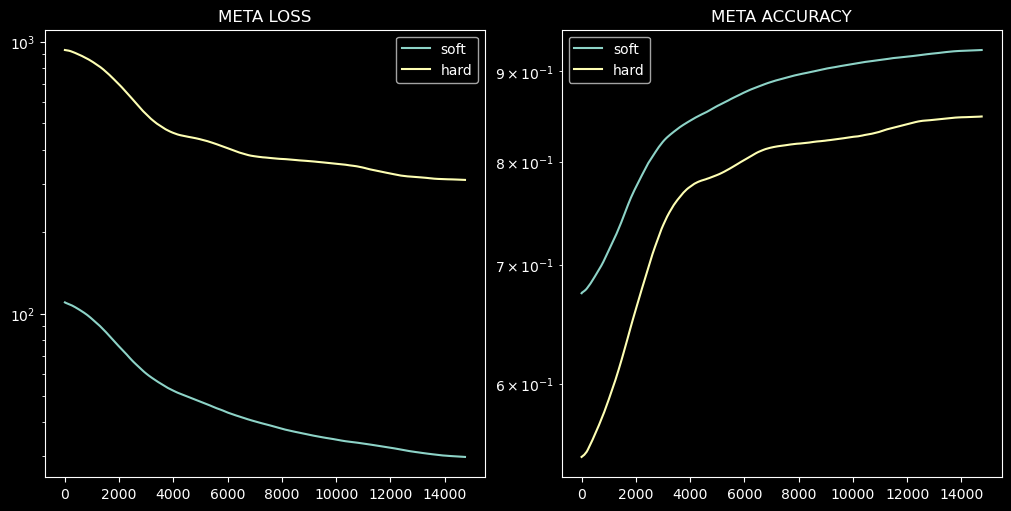

In [69]:
fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True
)
plot_losses(
    gnn_results["losses"], aux_log, (fig, axs[0]), title="META LOSS", plot_hard=True
)
plot_losses(
    gnn_results["losses"],
    aux_log,
    (fig, axs[1]),
    plot_accuracy=True,
    title="META ACCURACY",
    plot_hard=True,
)

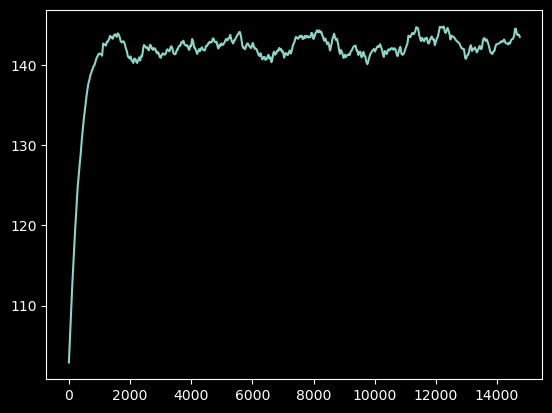

In [81]:
v = len(gnn_results["reset_steps"]) // 10
plt.plot(np.convolve(gnn_results["reset_steps"], np.ones(v) / v, mode="valid"))

In [70]:
# Get the inner loop losses
from boolean_nca_cc.training.evaluation import evaluate_gnn_stepwise

In [75]:
key = jax.random.PRNGKey(42)
wires_gnn, logits_gnn = gen_circuit(key, layer_sizes, arity=arity)
step_metrics = evaluate_gnn_stepwise(
    gnn,
    wires_gnn,
    logits_gnn,
    x,
    y0,
    input_n,
    n_message_steps=100,
    arity=arity,
    hidden_dim=hidden_dim,
    loss_type="l4",
)

Evaluating GNN steps:   0%|          | 0/100 [00:00<?, ?it/s]

In [76]:
aux_log_stepwise = [
    {"accuracy": acc, "hard_accuracy": hard_acc, "hard_loss": hard_loss}
    for acc, hard_acc, hard_loss in zip(
        step_metrics["soft_accuracy"],
        step_metrics["hard_accuracy"],
        step_metrics["hard_loss"],
    )
]

In [77]:
step_metrics.keys()

dict_keys(['step', 'soft_loss', 'hard_loss', 'soft_accuracy', 'hard_accuracy', 'logits_mean'])

In [78]:
gnn_log_results = {
    "losses": step_metrics["soft_loss"],
    "aux_log": aux_log_stepwise,
}

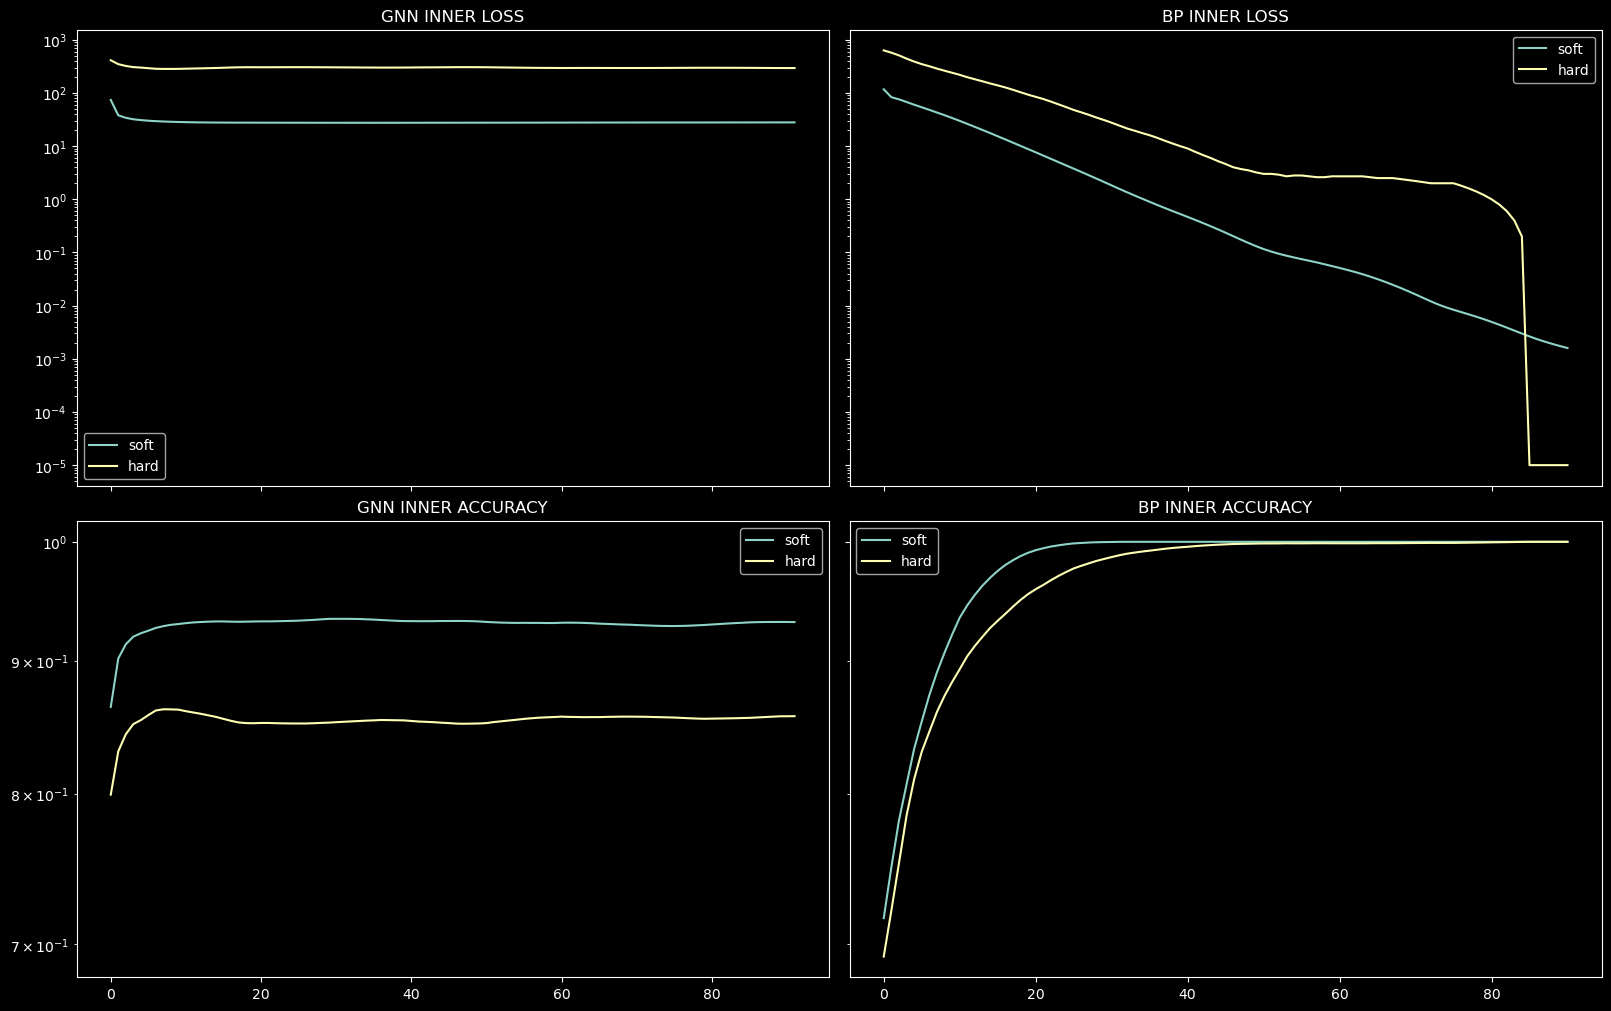

In [79]:
# Compare GNN and BP

fig, axs = plt.subplots(
    2, 2, figsize=(16, 10), sharey="row", sharex="col", constrained_layout=True
)

for method, axs_method, results in zip(
    ["GNN", "BP"], axs.T, [gnn_log_results, bp_results]
):
    for metric, ax in zip(["loss", "accuracy"], axs_method):
        if metric == "loss":
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER LOSS",
            )
        else:
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER ACCURACY",
                plot_accuracy=True,
            )

### Pool

In [41]:
from boolean_nca_cc.training.pool import GraphPool, initialize_graph_pool

In [45]:
init_pool = initialize_graph_pool(
    jax.random.PRNGKey(42),
    pool_size=1024,
    # circuit params
    layer_sizes=layer_sizes,
    arity=arity,
    input_n=input_n,
    # graph params
    hidden_dim=hidden_dim,
    loss_value=loss,
    wiring_mode="fixed",
)

[[3 5 7 7 7 4 5 4 0 2 5 3 5 2 2 5]
 [6 2 3 7 0 6 6 6 2 2 3 5 0 7 1 2]
 [4 3 0 0 1 0 3 1 5 4 6 4 7 1 6 1]
 [6 7 0 1 5 2 1 1 4 0 4 7 3 3 4 6]]


In [52]:
init_pool.wires[0][3], init_pool.wires[0][2]

(Array([[3, 5, 7, 7, 7, 4, 5, 4, 0, 2, 5, 3, 5, 2, 2, 5],
        [6, 2, 3, 7, 0, 6, 6, 6, 2, 2, 3, 5, 0, 7, 1, 2],
        [4, 3, 0, 0, 1, 0, 3, 1, 5, 4, 6, 4, 7, 1, 6, 1],
        [6, 7, 0, 1, 5, 2, 1, 1, 4, 0, 4, 7, 3, 3, 4, 6]], dtype=int32),
 Array([[3, 5, 7, 7, 7, 4, 5, 4, 0, 2, 5, 3, 5, 2, 2, 5],
        [6, 2, 3, 7, 0, 6, 6, 6, 2, 2, 3, 5, 0, 7, 1, 2],
        [4, 3, 0, 0, 1, 0, 3, 1, 5, 4, 6, 4, 7, 1, 6, 1],
        [6, 7, 0, 1, 5, 2, 1, 1, 4, 0, 4, 7, 3, 3, 4, 6]], dtype=int32))

In [25]:
idxs, graphs, batch_of_wires, batch_of_logits = init_pool.sample(
    jax.random.PRNGKey(42), 16
)

In [26]:
graphs.nodes["logits"].sum(), idxs

(Array(0., dtype=float32),
 Array([ 196,   18,  183,  193,  653,  363,  385,  295,    6,  258,  552,
        1010,  409,  475,  972,  786], dtype=int32))

In [29]:
losses, updated_graphs = nnx.vmap(loss_fn, in_axes=(None, 0, 0))(
    gnn, graphs, batch_of_wires
)

In [30]:
updated_graphs.nodes["logits"].sum(), idxs

(Array(-152602.31, dtype=float32),
 Array([ 196,   18,  183,  193,  653,  363,  385,  295,    6,  258,  552,
        1010,  409,  475,  972,  786], dtype=int32))

In [31]:
updated_batch_of_logits = jax.vmap(extract_logits_from_graph, in_axes=(0, None))(
    updated_graphs, [l.shape[1:] for l in batch_of_logits]
)

In [32]:
new_pool = init_pool.update(idxs, updated_graphs)

In [33]:
new_idxs, new_graphs, new_batch_of_wires, new_batch_of_logits = new_pool.sample(
    jax.random.PRNGKey(42), 16
)

In [34]:
(
    new_graphs.nodes["logits"].sum(),
    sum(jax.tree.map(lambda x: x.sum(), new_batch_of_logits)),
)

# Update cprrect

(Array(-152602.31, dtype=float32), Array(-147320.38, dtype=float32))

In [36]:
new_pool = initialize_graph_pool(
    jax.random.PRNGKey(42),
    pool_size=1024,
    # circuit params
    layer_sizes=layer_sizes,
    arity=arity,
    input_n=input_n,
    # graph params
    hidden_dim=hidden_dim,
    loss_value=loss,
)

In [38]:
init_pool.reset_fraction(
    jax.random.PRNGKey(43), 0.1, new_pool.graphs, new_pool.wires, new_pool.logits
)

GraphPool(size=1024, graphs=GraphsTuple(nodes={'gate_id': Array([[  0,   1,   2, ..., 237, 238, 239],
       [  0,   1,   2, ..., 237, 238, 239],
       [  0,   1,   2, ..., 237, 238, 239],
       ...,
       [  0,   1,   2, ..., 237, 238, 239],
       [  0,   1,   2, ..., 237, 238, 239],
       [  0,   1,   2, ..., 237, 238, 239]], dtype=int32), 'group': Array([[0, 0, 0, ..., 5, 6, 7],
       [0, 0, 0, ..., 5, 6, 7],
       [0, 0, 0, ..., 5, 6, 7],
       ...,
       [0, 0, 0, ..., 5, 6, 7],
       [0, 0, 0, ..., 5, 6, 7],
       [0, 0, 0, ..., 5, 6, 7]], dtype=int32), 'hidden': Array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 

In [119]:
first_graph = jax.tree.map(lambda x: x[0], new_graphs)
first_graph.nodes["logits"].shape

first_logits = extract_logits_from_graph(
    first_graph, [l.shape[1:] for l in batch_of_logits]
)
sum(jax.tree.map(lambda x: x.sum(), first_logits)), first_graph.nodes["logits"].sum()

(Array(-2639.108, dtype=float32), Array(-2734.4316, dtype=float32))

## Attention

In [144]:
from boolean_nca_cc.models.self_attention import (
    CircuitSelfAttention,
)

In [145]:
hidden_dim = 64
n_message_steps = 10
graph = build_graph(logitsbp, wires, input_n, arity, hidden_dim=hidden_dim)

In [146]:
attn = CircuitSelfAttention(
    hidden_dim=hidden_dim,
    num_heads=4,
    num_layers=4,
    arity=arity,
    dropout_rate=0.1,
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    n_node=int(graph.n_node[0]),
)

opt_fn = optax.adamw(1e-3, weight_decay=1e-5)
opt = nnx.Optimizer(attn, opt_fn)

In [147]:
updated_graph = attn(graph)

In [148]:
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(attn, graph)
opt.update(grads)
(loss, aux), grads = nnx.value_and_grad(loss_fn, has_aux=True)(attn, graph)
assert any(jax.tree.leaves(jax.tree.map(lambda x: x.any(), grads))), "No grads"

In [149]:
attn_results = train_model(
    key=0,
    # CIRCUIT PARAMS
    layer_sizes=layer_sizes,
    x_data=x,
    y_data=y0,
    arity=arity,
    # TRAINING PARAMS
    epochs=2**15,
    n_message_steps=1,
    meta_batch_size=256,
    # WIRING MODE PARAMS
    wiring_mode="random",
    wiring_fixed_key=jax.random.PRNGKey(42),
    # LOSS PARAMS
    loss_type="l4",
    # OPTIMIZER PARAMS
    learning_rate=1e-3,
    weight_decay=1e-5,
    # LEARNING RATE SCHEDULER
    lr_scheduler="linear_warmup",
    # INITIAL GNN AND OPTIMIZER
    hidden_dim=hidden_dim,
    init_model=attn,
    # POOL PARAMS : current mean avg of 100 steps before reset
    use_pool=True,
    pool_size=1024,
    reset_pool_fraction=0.075,
    reset_pool_interval=2**5,
    reset_strategy="combined",
)

Training GNN:   0%|          | 0/32768 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [118]:
# Get the inner loop losses
from boolean_nca_cc.training.evaluation import evaluate_model_stepwise

In [126]:
key = jax.random.PRNGKey(42)
wires_gnn, logits_gnn = gen_circuit(key, layer_sizes, arity=arity)
step_metrics_attn = evaluate_model_stepwise(
    attn,
    wires_gnn,
    logits_gnn,
    x,
    y0,
    input_n,
    n_message_steps=100,
    arity=arity,
    hidden_dim=hidden_dim,
    loss_type="l4",
)

Evaluating GNN steps:   0%|          | 0/100 [00:00<?, ?it/s]

In [128]:
aux_log_stepwise_attn = [
    {"accuracy": acc, "hard_accuracy": hard_acc, "hard_loss": hard_loss}
    for acc, hard_acc, hard_loss in zip(
        step_metrics_attn["soft_accuracy"],
        step_metrics_attn["hard_accuracy"],
        step_metrics_attn["hard_loss"],
    )
]

In [129]:
step_metrics_attn.keys()

dict_keys(['step', 'soft_loss', 'hard_loss', 'soft_accuracy', 'hard_accuracy', 'logits_mean'])

In [132]:
attn_log_results = {
    "losses": step_metrics_attn["soft_loss"],
    "aux_log": aux_log_stepwise_attn,
}

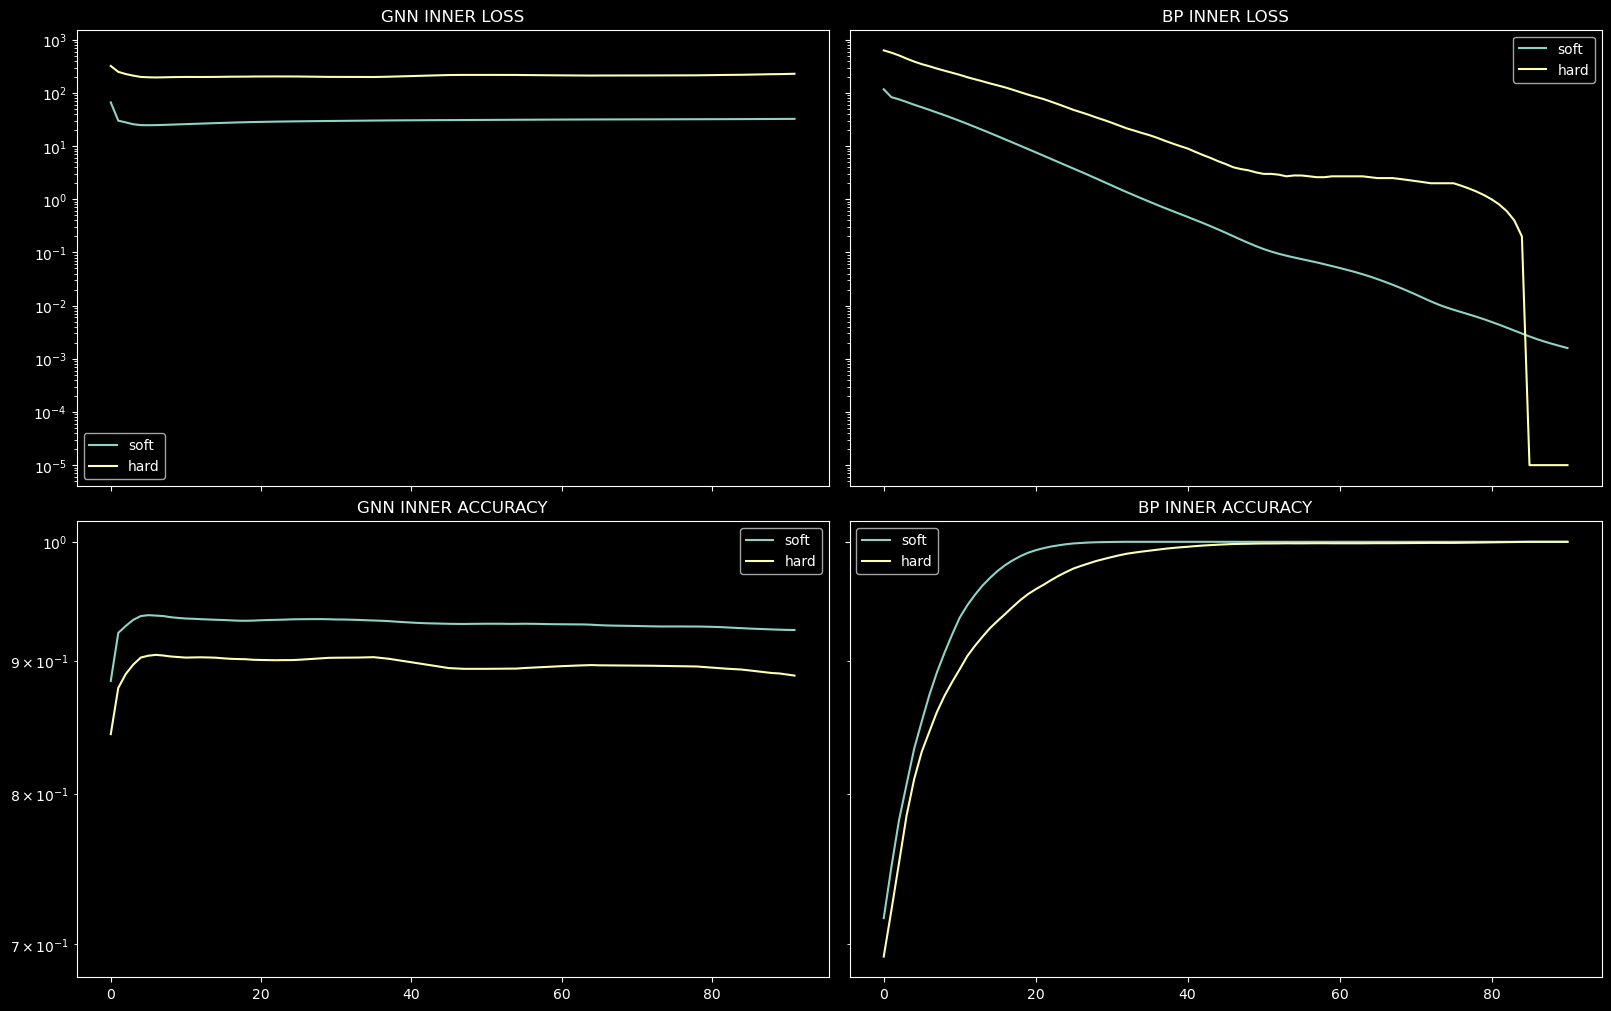

In [123]:
# Compare GNN and BP

fig, axs = plt.subplots(
    2, 2, figsize=(16, 10), sharey="row", sharex="col", constrained_layout=True
)

for method, axs_method, results in zip(
    ["GNN", "BP"], axs.T, [gnn_log_results, bp_results]
):
    for metric, ax in zip(["loss", "accuracy"], axs_method):
        if metric == "loss":
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER LOSS",
            )
        else:
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER ACCURACY",
                plot_accuracy=True,
            )